## Task List
### 1.
- [x] Univariate ADF for all variables and decide whether differencing/log-differencing is required. State which one used and why and put results into sentences.
- [ ] For outcome variable, report more detailed ADF and CADF as follows:
    - [ ] Decide whether to use Case 4 or 2. Write equations for hypothesis tests, null and alternative hypotheses, and provide evidence whether to accept or reject.
    - [ ] Was there a unit root? Was there a drift or trend or neither?
    - [ ] For the CADF test, include your main explanatory variables (or their stationary transformations if required) in the test regression.
    - [ ]  Do the ADF and CADF test agree or give conflicting results? Based on the results of the test(s), should you difference the data before moving on or not?

### 2. 
- [x] Used transformed data to build univariate ARIMA model for stationary outcome variable.
- [x] State and report the selection criteria you used (AIC/BIC, Q-test on residuals, etc.) and any model checking/refining that you performed (e.g., dropping insignificant coefficients, etc.)
- [x] Write out the final estimated model as a linear equation AND in lag polynomial form

### 3. 
- [x] Forecast your model on a hold-out sample and plot the forecast along with the realized series for
comparison.

### 4.
- [x] First, estimate a model for the relationship between the stationary outcome variable and the stationary versions of the main explanatory variables using OLS
- [x] Second, estimate the regression model while fitting an ARMA model to the residuals
- [x] Third, either (1) add lags of Y and/or X’s using dynlm() until the residual autocorrelation is reduced, or (2) use HAC/Newey-West standard errors.
- [x] Compare estimates of the coefficients and standard errors on the two or three main explanatory variables from these three approaches
- [ ] For your preferred model among the above, provide evidence for whether or not there is autocorrelation remaining in the residuals
- [ ] Write out the equation(s) for the model including any model equation for the residuals if applicable.

### 5.
- [ ] Should your model be interpreted as the causal effect of your X variable(s) on Y, or a predictive/correlational relationship? In other words, do we have reason to believe the X variable(s) are
exogenous to Y or are they jointly determined with Y as the equilibrium of some market process orphysical process?
- [ ] Are there important omitted variables that might be correlated with both X and
Y, i.e., is X picking up the effect of some other related variable that’s not in the model? Feel free to speculate, but be thoughtful.

### 6.
- [ ] . Suppose you thought the answer to (5) should be “Yes, these are causal effects”. Now run a regression of
the stationary version of your outcome variable on the stationary version of your additional one or two minor explanatory variables.
- [ ] Then run a second regression including all of the explanatory variables (both the two or three major ones and the one or two additional ones).
- [ ]  Discuss the differences in results between these regressions in terms of changes in magnitude and statistical significance of the
less important regressors when you add/subtract the more important regressors.
- [ ]  When you omit the most important regressors, could the relatively minor ones capture some of this variation and “appear’ ’
to be important, but could their importance go away once you control for the big ones? Give a brief discussion of what you think is going on.


# HW2
For this assignment I will be using a dataset of historical prices for electricity futures in MISO and PJM markets at their central hubs, respectively. More specifically, we will be using a target variable of MISO/PJM Real-time Locational Marginal Pricing (RTLMP) spread denoted in ($/MWh), that is the diffrence in price for electricity futures between MISO and PJMC. We will be examining the relationship of price spread with several independent variables, which are listed below. Note that each variable is a daily average price/physical quantity.
- MISO/PJMC Real-time Congestion - Difference between RT congestion between MISO and PJMC ($/MWh)
- MISO/PJMC Real-time Load - Difference between RT load between MISO and PJMC (MW)
- MISO/PJMC Net Load - Difference between Net Load between MISO and PJMC (MW)

In addition, the following ancillary variables will be included for the analysis
- PJMC Load Difference - Difference between RT load and forecasted load for PJM (MW)
- MISO Load Difference - Difference between RT load and forecasted load for MISO (MW)

In [1]:
# Numerical/Statistical Libraries
import pandas as pd
import scipy as sp
import numpy as np
import statsmodels.api as sm 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller as adf
from statsmodels.regression.linear_model import OLS, OLSResults
from sklearn.model_selection import train_test_split

# Plotting Libraries
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

# Various Utilities
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# Reading in data and preparing relevant data for analysis.
data = pd.read_csv(r"C:\Users\Jared\OneDrive\Mines\FALL2024\EBGN594\MISO_PJM_data\atc_data.csv")

# Strip whitespace from column names
data.columns = data.columns.str.strip()

subset_columns = [
    'DATE',
    'MISO/PJMC RTLMP', 
    'MISO/PJMC RT CONG', 
    'MISO/PJMC RT LOAD', 
    'MISO/PJM Net Load', 
    'PJM LOAD DIFF', 
    'MISO LOAD DIFF'
]

# Setting index to be a datetime index
data['Date'] = pd.to_datetime(data['DATE'])  
data.set_index('Date', inplace=True)  

# Create the subset of data with the relevant columns
data = data[subset_columns]

## 1. Unit Root Testing
### ADF For All Series
The cell below outputs the results of the Augmented Dickey-Fuller (ADF) test for each data series. We test for a unit root using the following hypothesis test: 

\begin{align*}
    H_0: \text{The data has a unit root (nonstationary)} \\
    H_a: \text{The data does not have a unit root (stationary)}
\end{align*}

We use the p-values calculated by running the ADF test to determine whether the data is stationary. As can be seen by the table, **all the series have negligible p-values**. Since all of the p-values are less than .05, we can **reject the null hypothesis for every series on a 95% confidence interval**, which indicates that all data series are stationary. No differencing is required to make the data stationary

In [4]:
adf_results_list = []

# Loop through each column in the dataset and compute the ADF test
for column in data.columns[1:]:
    result = adf(data[column])
    adf_results_list.append({
        'Series': column,
        'Test Statistic': result[0],
        'p-value': result[1],
        'Lags Used': result[2],
        'Observations Used': result[3],
        '1% Critical Value': result[4]['1%'],
        '5% Critical Value': result[4]['5%'],
        '10% Critical Value': result[4]['10%'],
        'Max Information Criterion': result[5]
    })

adf_df = pd.DataFrame(adf_results_list)

y=data['MISO/PJMC RTLMP']
adf_df


,Series,Test Statistic,p-value,Lags Used,Observations Used,1% Critical Value,5% Critical Value,10% Critical Value,Max Information Criterion
0,MISO/PJMC RTLMP,-23.659790,0.000000e+00,2,1825,-3.433938,-2.863125,-2.567614,14726.005259
1,MISO/PJMC RT CONG,-8.933435,9.676098e-15,10,1817,-3.433954,-2.863132,-2.567618,13078.776148
2,MISO/PJMC RT LOAD,-6.067498,1.172210e-07,12,1815,-3.433958,-2.863134,-2.567618,34245.632290
3,MISO/PJM Net Load,-11.358989,9.576794e-21,5,1822,-3.433944,-2.863128,-2.567615,34239.612843
4,PJM LOAD DIFF,-4.874092,3.915836e-05,15,1812,-3.433964,-2.863136,-2.567620,22284.817213
5,MISO LOAD DIFF,-5.038647,1.859916e-05,21,1806,-3.433976,-2.863142,-2.567623,30273.105610


## 2. ARIMA Model

### ACF and PACF
First, we plot the autocorrelation function and partial autocorrelation function to help us determine model parameters. As can be seen in the chart below, there is a significant spike on both charts and p=q=1 that lies outside of the 95% confidence interval. We will use these as parameters when we create our model. Upon further examination, the **BIC is indeed minimized with ARMA(1,1,1)**, so this model will be used for the rest of the analysis.

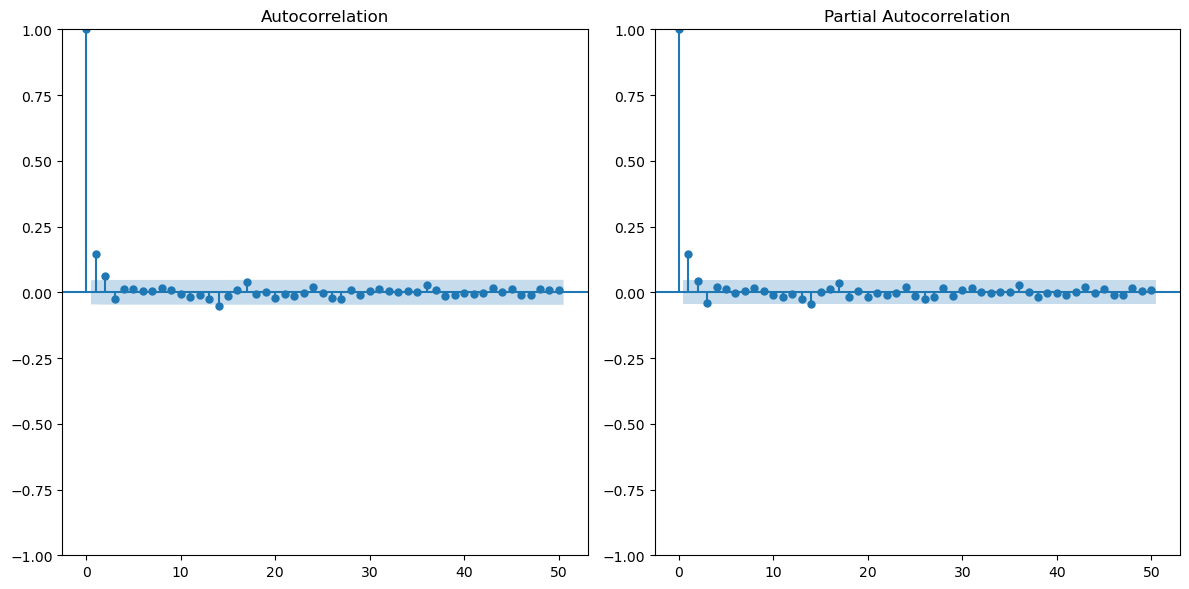

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plot_acf(y, lags=50, ax=ax[0])
plot_pacf(y, lags=50, ax=ax[1])

plt.tight_layout()
plt.show()

### Model Selection
The criterion used to determine the best model parameters is the Bayesian Information Criteria. When we use the ARIMA(1,1,1) model, we obtain a value of 12221.522. This number is quite high, which indicates that the model may still have a poor fit with the data. The estimated parameters for the model, namely the **AR(1) and MA(1) coefficients, are .1488 and -.9996 respectively**. Each of these coefficients have a negligible p-value as well, indicating that they are **most likely statistically significant**. The "Sigma2" coefficient denotes the variance of the residuals. The **variance of residuals is quite high and appears to also be statistically significant**. Some other interesting facts about the model to note are some of the diagnostic tests. The **LB Q-stat has a p-value of .78, which entails that there is a high probability of serial autocorrelation in the model**. The **JB Test Statistic is extremely low with a low p-value**, which means the **residuals are not normally distributed**. Finally, the **p-value for Heteroskedasticity is 0**, which means that the **residuals are most likely heteroskedastic (i.e. the residuals have non-constant variance.)**

Note that the results do not include a constant. So the equation for the linear model is as such:

\begin{align*}
\Delta y_t =.1488 \Delta y_{t-1} - .9996 \epsilon_{t-1} + \epsilon_t
\end{align*}

where $\epsilon_t$ is some white noise term at time $t$. Equivalently, the equation in lag polynomial form is

\begin{align*}
(1-1.1483L+.1483L^2)y_t=(1-.9996L)\epsilon_t
\end{align*}

In [6]:
y_train,y_test=train_test_split(data['MISO/PJMC RTLMP'],test_size=.20,random_state=42,shuffle=False)

model = ARIMA(y_train, order=(1,1,1)).fit()

print(model.summary())

                               SARIMAX Results                                
Dep. Variable:        MISO/PJMC RTLMP   No. Observations:                 1462
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6099.831
Date:                Mon, 07 Oct 2024   AIC                          12205.662
Time:                        18:32:47   BIC                          12221.522
Sample:                    05-30-2019   HQIC                         12211.578
                         - 05-30-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1483      0.009     17.063      0.000       0.131       0.165
ma.L1         -0.9996      0.023    -43.596      0.000      -1.045      -0.955
sigma2       246.7027      4.736     52.088      0.0

## 3. ARIMA Forecast
The forecast will use the test subset of the data to formulate a forecast with 95% confidence interval. Note that the forecast quickly converges to a constant, which in this case is the mean of the training data. The mean is $\approx$ -.7501 $/MWh, indicating that on average, electricity prices in the PJMC market are slightly higher than prices in the MISO market, which would be an interesting fact for traders to consider. Also, with respect to the hypothesized stationarity of the data, and the fast convergence to the mean, this seems to indicate that the time-series data exhibits mean-reverting behavior. 

Series Mean:  -0.7501043053086276


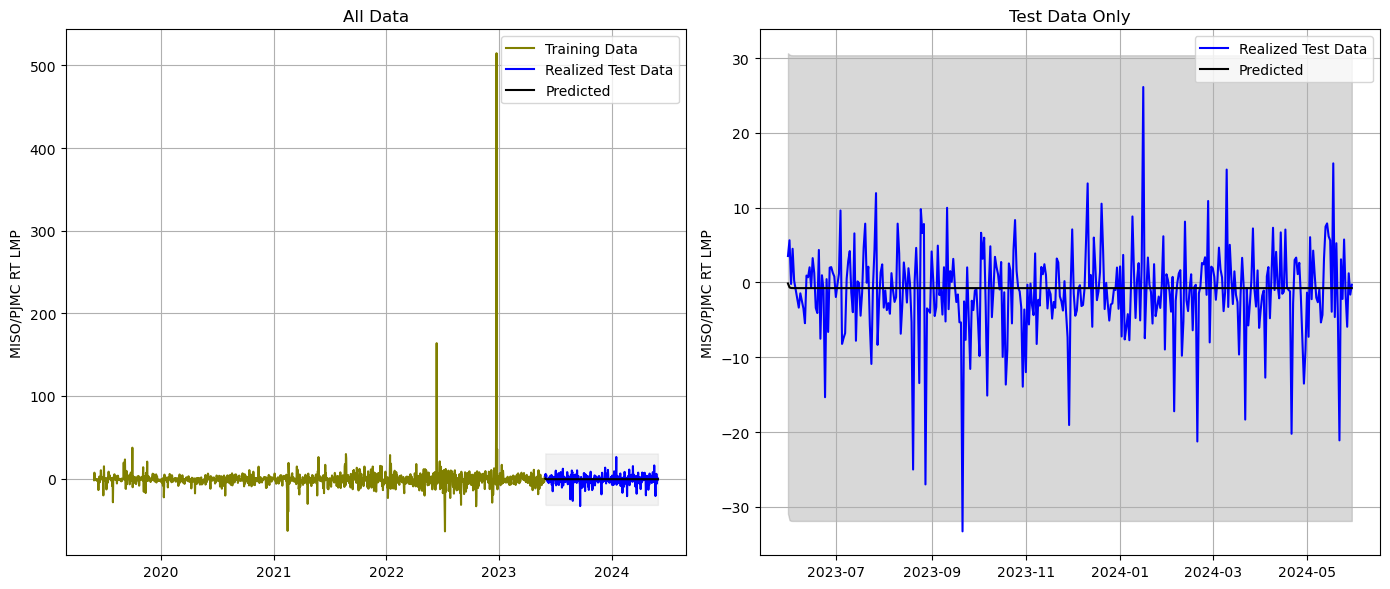

In [7]:
# Use statsmodels to generate forecasted values and confidence interval
forecast = model.get_forecast(steps=len(y_test))
forecast_mean = forecast.predicted_mean
ci = forecast.conf_int()

print('Series Mean: ',forecast_mean[-1])


# Create a 1x2 subplot 
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# First subplot: Plot all training+testing data with forecast and confidence intervals on test data
ax[0].plot(y_train, color='olive', label='Training Data')
ax[0].plot(y_test.index, y_test, color='blue', label='Realized Test Data')
ax[0].plot(y_test.index, forecast_mean, color='black', label='Predicted')
ax[0].fill_between(y_test.index, 
                   ci.iloc[:, 0],  # Lower bound
                   ci.iloc[:, 1],  # Upper bound
                   color='gray', alpha=0.1)
ax[0].set_title('All Data')
ax[0].set_ylabel('MISO/PJMC RT LMP')
ax[0].legend()
ax[0].grid(True)

# Second subplot: Plot only testing data with forecast and confidence intervals
ax[1].plot(y_test.index, y_test, color='blue', label='Realized Test Data')
ax[1].plot(y_test.index, forecast_mean, color='black', label='Predicted')
ax[1].fill_between(y_test.index, 
                   ci.iloc[:, 0], 
                   ci.iloc[:, 1],  
                   color='gray', alpha=0.3)
ax[1].set_title('Test Data Only')
ax[1].set_ylabel('MISO/PJMC RT LMP')
ax[1].legend()
ax[1].grid(True)


plt.tight_layout()
plt.show()

## 4. Handling Residuals
Here we will use three different methods for handling residual errors: standard OLS error estimations, OLS with HAC standard errors, and ARMA residuals.

| Variable               | OLS Coefficients | OLS Std. Errors | HAC Std. Errors | ARMA Residual Coefficients | ARMA Residual Std. Errors |
|------------------------|------------------|-----------------|----------------|----------------------------|---------------------------|
| const                  | 0.804944         | 1.599350        | 1.865723        | 0.804944                   | 0.403920                  |
| MISO/PJMC RT CONG      | -0.877222        | 0.020984        | 0.461632        |                  |                  |
| MISO/PJMC RT LOAD      | 0.000256         | 0.000053        | 0.000157        |                   |                   |
| MISO/PJM Net Load      | -0.000006        | 0.000075        | 0.000066        |               |                   |

| AR(1) Coefficient  |                  |                 |                | -0.877222                  | 0.104662                  |
| MA(1) Coefficient  |                  |                 |                | 0.000256                   | 0.110352                  |
| Sigma^2            |                  |                 |                | -0.000006                  | 0.658457                  |

The table above encapsulates information for each comparison of model errors.
- **OLS with Default Error:** With 

In [8]:
# Assuming 'data' is available and contains the necessary columns.
# Define the regressors and dependent variable
regressors = ['MISO/PJMC RT CONG', 'MISO/PJMC RT LOAD', 'MISO/PJM Net Load']
Y = data['MISO/PJMC RTLMP']
X = data[regressors]
X = sm.add_constant(X)

# OLS Estimation
ols_model = OLS(Y, X)
ols_results = ols_model.fit()

# Using ARMA(1,1) model on the residuals
residuals = ols_results.resid
arma_resid = ARIMA(residuals, order=(1, 0, 1)).fit()
print(arma_resid.summary())

# Using HAC errors on the OLS model
ols_hac = ols_results.get_robustcov_results(cov_type='HAC', maxlags=1)

# Extract coefficients from each model
ols_data = {
    'Variable': X.columns,
    'OLS Coefficients': ols_results.params.values,
    'OLS Std. Errors': ols_results.bse.values,
    'HAC Std. Errors': ols_hac.bse
}

arma_data = {
     'ARMA Residual Coefficients': ols_results.params.values,  # Same coefficients, different errors
    'ARMA Residual Std. Errors': arma_resid.bse[:len(X.columns)],  # First part of ARMA summary
}

# Turning each into tables
ols_table = pd.DataFrame(ols_data)
arma_table = pd.DataFrame(arma_data)

display(ols_table)
display(arma_table)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1828
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -7061.866
Date:                Mon, 07 Oct 2024   AIC                          14131.733
Time:                        18:32:47   BIC                          14153.777
Sample:                    05-30-2019   HQIC                         14139.864
                         - 05-30-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        8.44e-05      0.404      0.000      1.000      -0.792       0.792
ar.L1          0.2515      0.105      2.403      0.016       0.046       0.457
ma.L1         -0.0577      0.110     -0.523      0.6

,Variable,OLS Coefficients,OLS Std. Errors,HAC Std. Errors
0,const,0.804944,1.599350,1.865723
1,MISO/PJMC RT CONG,-0.877222,0.029084,0.461632
2,MISO/PJMC RT LOAD,0.000256,0.000053,0.000157
3,MISO/PJM Net Load,-0.000006,0.000075,0.000066


,ARMA Residual Coefficients,ARMA Residual Std. Errors
const,0.804944,0.403920
ar.L1,-0.877222,0.104662
ma.L1,0.000256,0.110352
sigma2,-0.000006,0.658457
